In [1]:
import pbjam as pb
import lightkurve as lk
import pickle

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]
download = False

In [3]:
if download:
    lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
    for q in range(2,17):
        lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))
    lc = lc.remove_outliers(4)

    edict = {'lc': lc}
    pickle_out = open("lc.pickle","wb")
    pickle.dump(edict, pickle_out)
    pickle_out.close()
else:
    pickle_in = open("lc.pickle","rb")
    edict = pickle.load(pickle_in)
    lc = edict['lc']

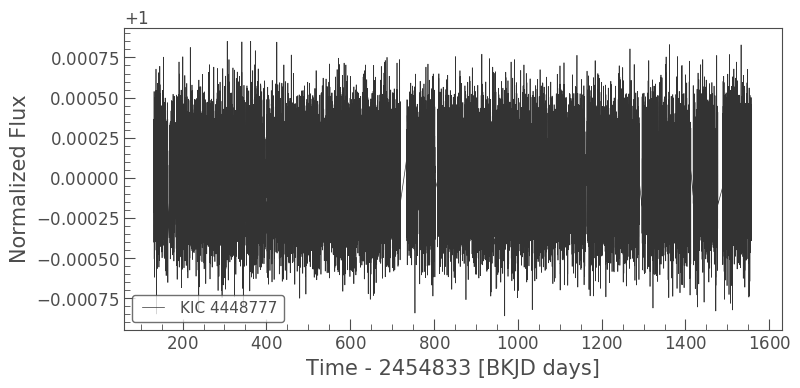

In [4]:
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=100.0).flatten()

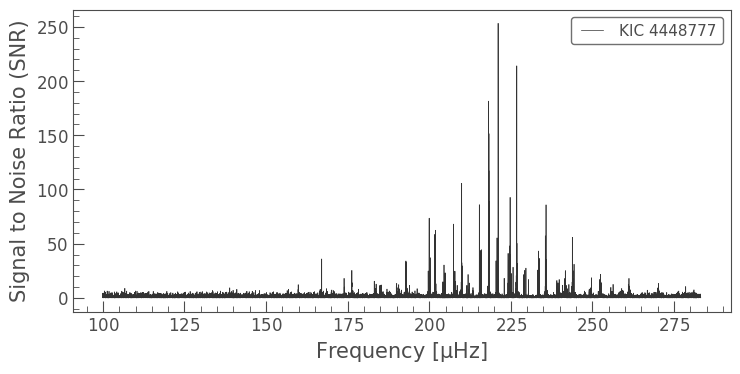

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

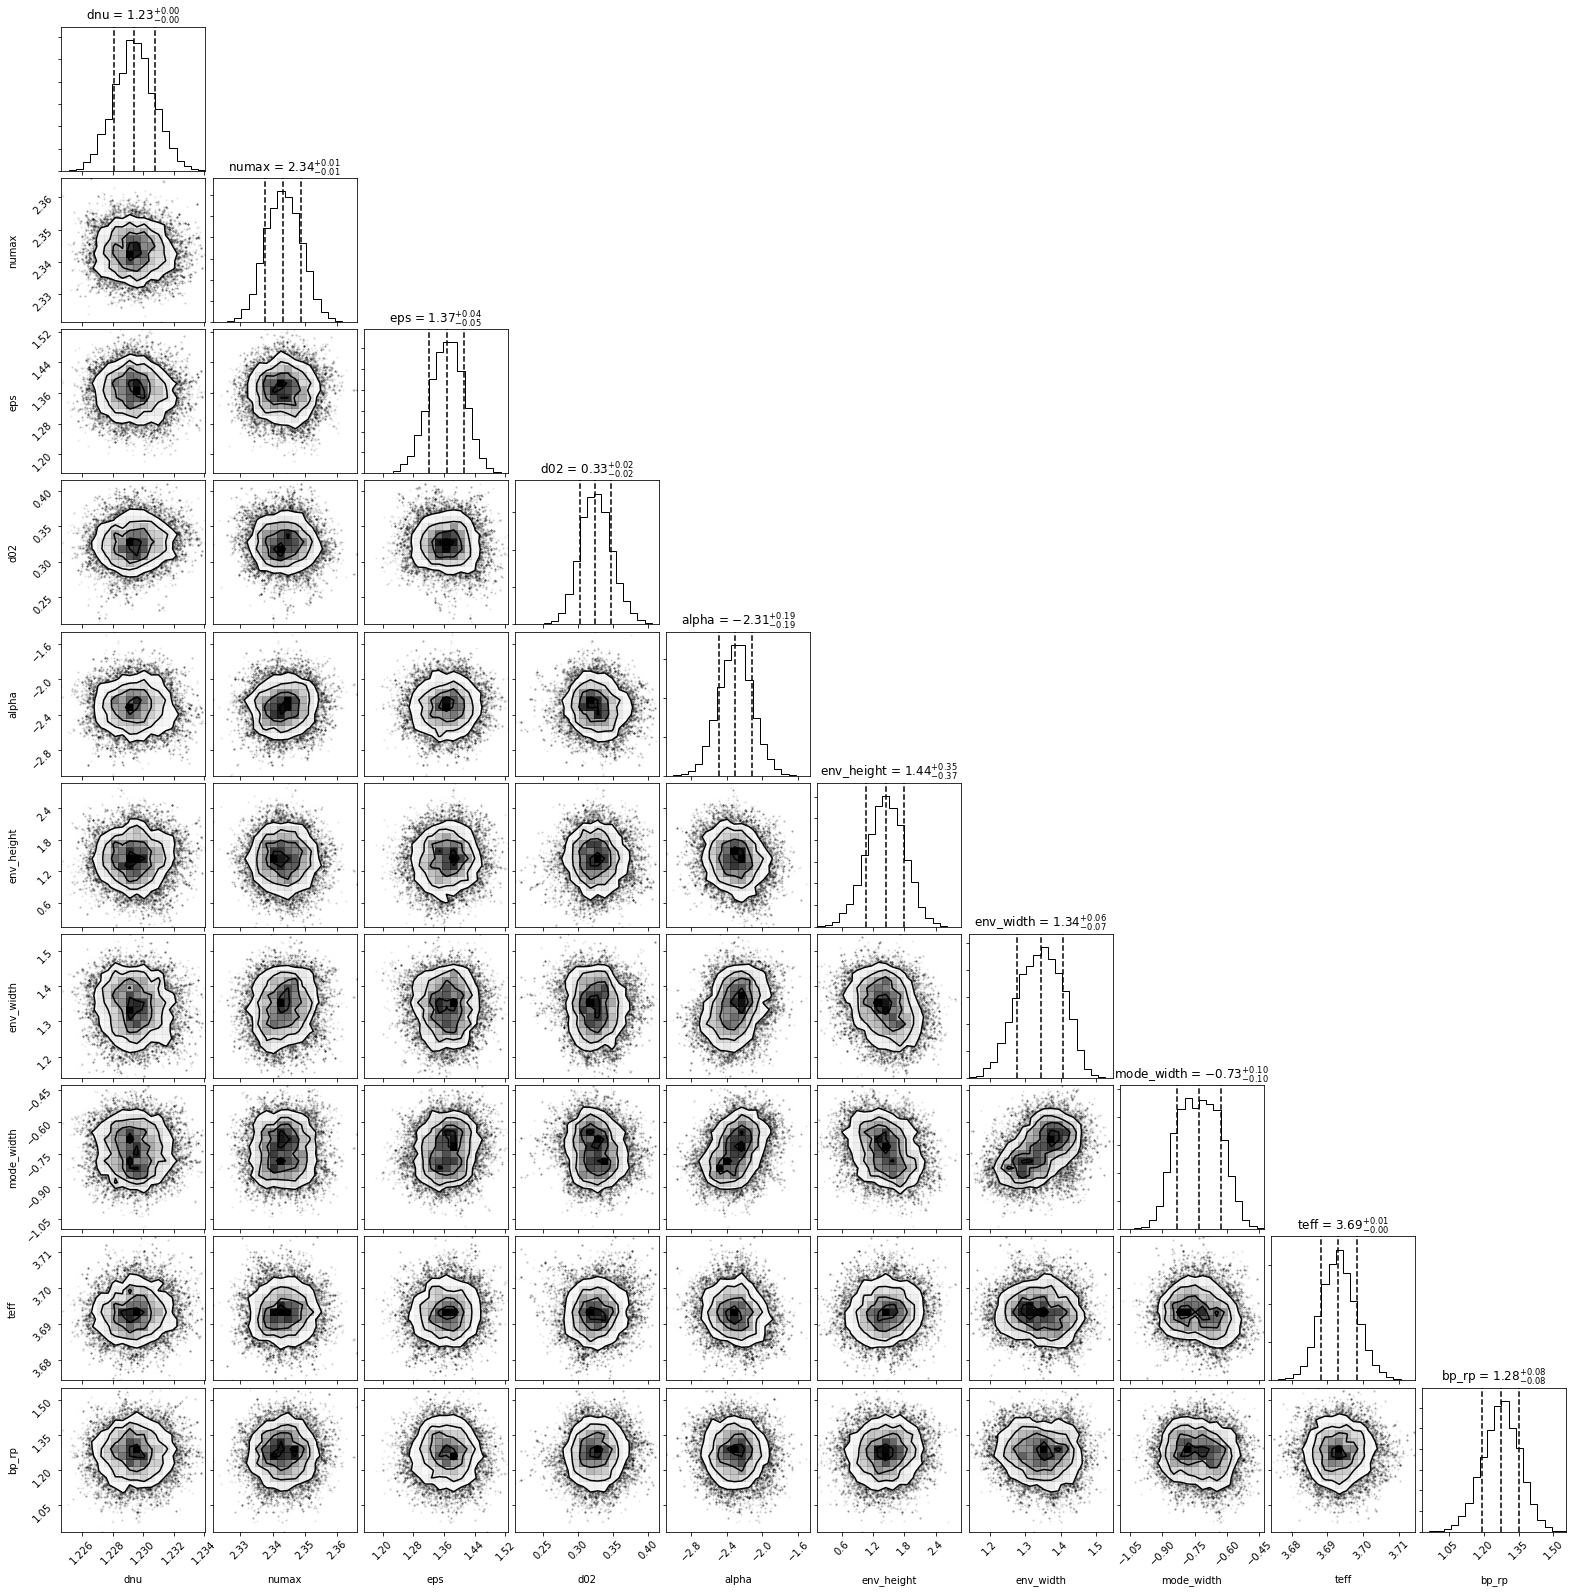

In [8]:
ep.plot_corner();

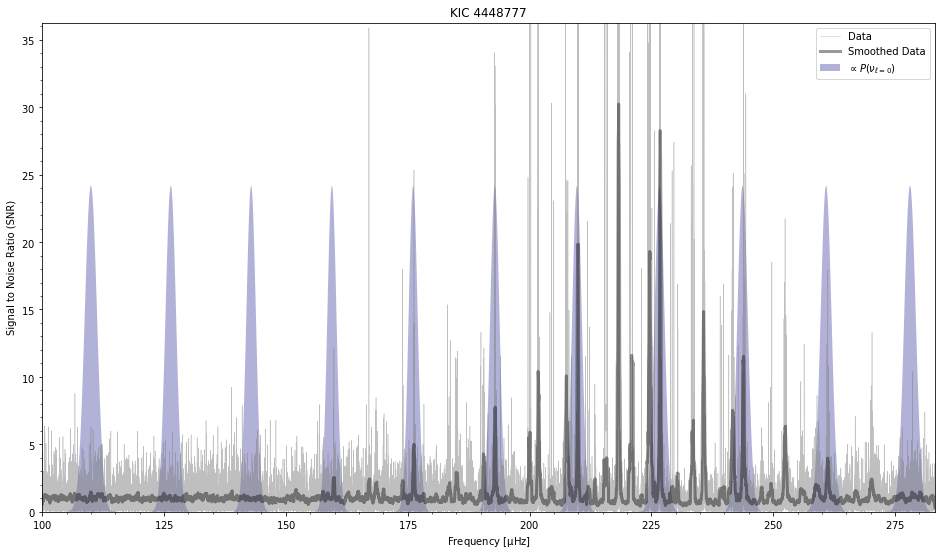

In [9]:
ep.plot(pg);

In [10]:
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=1, norders=10,
                                    store_chains=True)

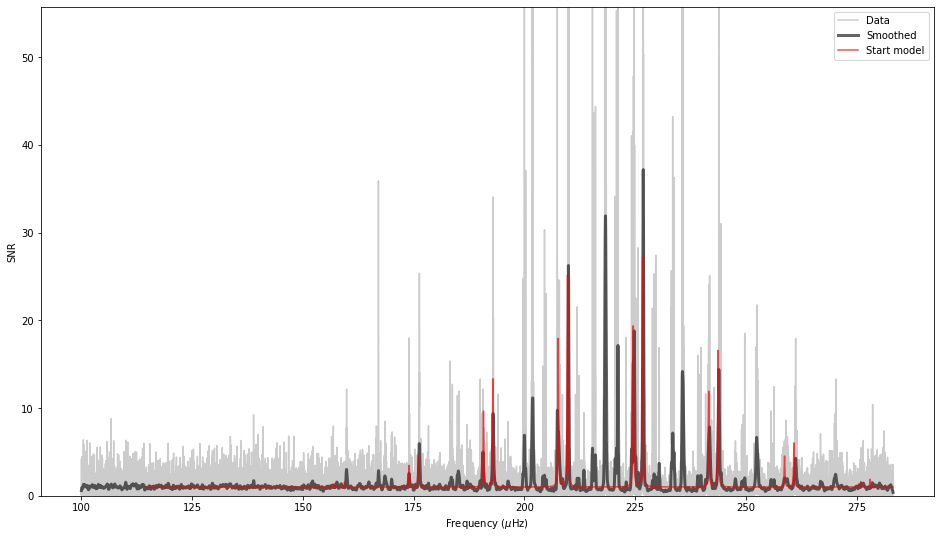

In [11]:
asy.plot_start();

In [12]:
asy_result = asy.run(burnin=1000, niter=1000)

emcee: Exception while calling your likelihood function:
  params: [ 1.69913515e+01  2.20542949e+02  1.34931413e+00  2.21381157e+00
  6.84547550e-03  1.46641031e+00  1.31782701e+00 -6.54949646e-01
  4.93420246e+03  1.32724296e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 846, in likelihood
    logp = self.lp(p)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 744, in __call__
    np.log10(p[8]), p[9]]))
  File "/Users/davies/Library/Python/3.6/lib/python/site-packages/statsmodels/nonparametric/kernel_density.py", line 196, in pdf
    var_type=self.var_type) / self.nobs)
  File "/Users/davies/Library/Python/3.6/lib/python/site-packages/statsmodels/nonparametric/_kernel_base.py", line 513, in gpke
    Kval[:, ii] = func(bw[ii], data[:, ii], data_predict[ii])
  File "/Users/davies/Library/Python/3.6/lib/python/site-packages/statsmodels/nonparametric/kernels.py", line 128, in gaussian
    return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 

KeyboardInterrupt: 

In [ ]:
asy.plot();

In [ ]:
asy.plot_corner();

In [ ]:
import pbjam
import importlib
importlib.reload(pbjam)
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

In [ ]:
import pickle

edict = {'f': pg.frequency.value, 'p': pg.power.value, 'a': asy_result}

pickle_out = open("pb.pickle","wb")
pickle.dump(edict, pickle_out)
pickle_out.close()

In [ ]:
pbag.plot_start_model();

In [ ]:
pbag.sample(model_type='simple', cores=4, tune=1500)

In [ ]:
pbag.plot_fit(thin=1);